<a href="https://colab.research.google.com/github/TiffanyIzzuddin/eye-training-/blob/main/with_cv2_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# preproceesing with cv2

In [ ]:
!git clone https://github.com/TiffanyIzzuddin/eye-disease-dataset.git

!ls eye-disease-dataset/dataset

fatal: destination path 'eye-disease-dataset' already exists and is not an empty directory.
cataract  diabetic_retinopathy	glaucoma  normal


In [ ]:
import cv2
import numpy as np

def preprocess_fundus_image(image_path):
    """
    Preprocesses a fundus image according to the given pipeline.

    Args:
        image_path (str): Path to the fundus image file.

    Returns:
        numpy.ndarray: Preprocessed image as a NumPy array.
    """
    # 1. Load the image
    img = cv2.imread(image_path)

    # 2. Separate RGB channels
    b, g, r = cv2.split(img)

    # 3. Invert the green channel
    g_inv = 255 - g

    # 4. Apply mean filter (background estimation)
    ksize = 15  # Kernel size for the mean filter
    g_mf = cv2.blur(g_inv, (ksize, ksize))

    # 5. Subtract background and add mean intensity
    g_nb = g_inv - g_mf
    g_corr = g_nb + np.mean(g_inv)

    # 6. Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g_clahe = clahe.apply(g_corr.astype(np.uint8))

    # 7. Apply Gaussian filter
    g_gf = cv2.GaussianBlur(g_clahe, (5, 5), 0)

    # 8. Normalize the image (min-max scaling)
    g_normalized = cv2.normalize(g_gf, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # (Optional) Merge the processed green channel back with the original R and B
    # img_processed = cv2.merge((b, g_normalized, r))

    return g_normalized

In [ ]:
# prompt: write the input dataset into dataframe called df that we could use the entire time in this project, and do mapping normal:0, glaucoma:1, cataract:2, diabetic retinopathy:3

import pandas as pd
import os

data_dir = 'eye-disease-dataset/dataset'

# Create an empty list to store the data
data = []

# Iterate through the subdirectories (disease categories)
for disease in os.listdir(data_dir):
  disease_dir = os.path.join(data_dir, disease)
  if os.path.isdir(disease_dir):  # Check if it's a directory
    for image_file in os.listdir(disease_dir):
      if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
          data.append([image_file, disease])

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['image', 'disease'])

# Mapping the diseases to numerical labels
disease_mapping = {
    'normal': 0,
    'glaucoma': 1,
    'cataract': 2,
    'diabetic_retinopathy': 3
}

df['label'] = df['disease'].map(disease_mapping)

# Print the first few rows of the DataFrame to verify
# print(df.head())
print(df)


                 image               disease  label
0     cataract_014.png              cataract      2
1        2226_left.jpg              cataract      2
2       2239_right.jpg              cataract      2
3       2225_right.jpg              cataract      2
4      _93_7584804.jpg              cataract      2
...                ...                   ...    ...
4212  10278_right.jpeg  diabetic_retinopathy      3
4213   10177_left.jpeg  diabetic_retinopathy      3
4214   11378_left.jpeg  diabetic_retinopathy      3
4215   10487_left.jpeg  diabetic_retinopathy      3
4216   1165_right.jpeg  diabetic_retinopathy      3

[4217 rows x 3 columns]


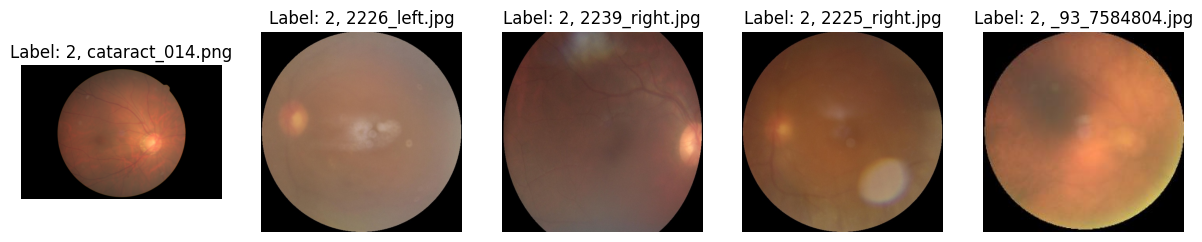

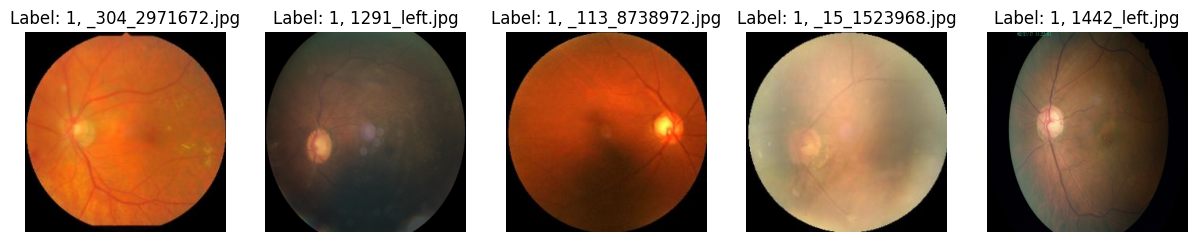

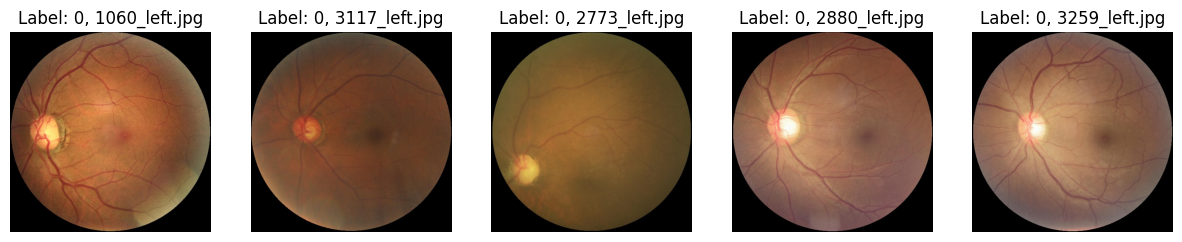

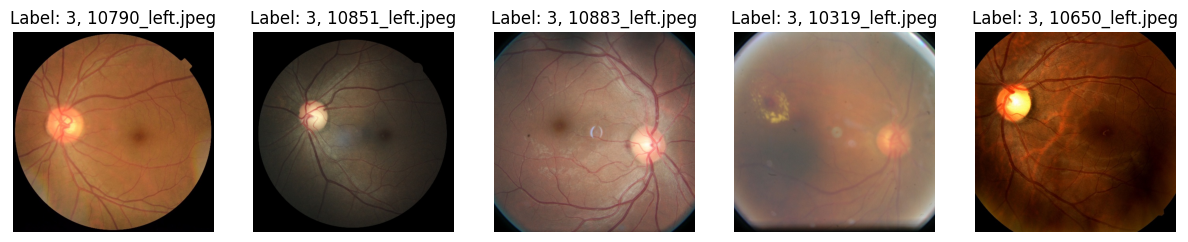

In [ ]:
# prompt: show 5 image in df to the left from each label

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it's already defined as in the previous code.

for label in df['label'].unique():
  subset = df[df['label'] == label].head(5) # Get the first 5 images for each label
  fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Create a figure with subplots
  for i, (index, row) in enumerate(subset.iterrows()):
      image_path = os.path.join(data_dir, row['disease'], row['image'])
      try:
          img = plt.imread(image_path)
          axes[i].imshow(img)
          axes[i].set_title(f"Label: {label}, {row['image']}")  # Show label and image filename
          axes[i].axis('off') # Hide axis
      except FileNotFoundError:
          print(f"Image not found: {image_path}")
          axes[i].axis('off') # Hide axis

  plt.show()


In [ ]:
# prompt: use df dataframe then do preprocessing preprocess_fundus_image to all of the image. save it to new dattaframe, so it can be used for training model

import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
import os

# Assuming df DataFrame is already created as in the provided code

# Create a new DataFrame to store preprocessed images
df_processed = pd.DataFrame(columns=['image_path','processed_image', 'disease', 'label'])

# Iterate through the DataFrame and preprocess each image
for index, row in df.iterrows():
    image_path = os.path.join(data_dir, row['disease'], row['image'])
    try:
        processed_image = preprocess_fundus_image(image_path)
        df_processed = pd.concat([df_processed, pd.DataFrame({'image_path': [image_path], 'processed_image': [processed_image], 'disease': [row['disease']], 'label': [row['label']]})], ignore_index=True)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Now df_processed contains the preprocessed images, which you can use for model training
print(df_processed.head())


                                          image_path  \
0  eye-disease-dataset/dataset/cataract/cataract_...   
1  eye-disease-dataset/dataset/cataract/2226_left...   
2  eye-disease-dataset/dataset/cataract/2239_righ...   
3  eye-disease-dataset/dataset/cataract/2225_righ...   
4  eye-disease-dataset/dataset/cataract/_93_75848...   

                                     processed_image   disease label  
0  [[159, 155, 155, 152, 152, 152, 155, 159, 159,...  cataract     2  
1  [[166, 166, 166, 166, 166, 166, 166, 166, 166,...  cataract     2  
2  [[183, 183, 183, 183, 183, 183, 183, 183, 183,...  cataract     2  
3  [[193, 193, 193, 193, 193, 193, 193, 193, 193,...  cataract     2  
4  [[170, 170, 170, 170, 170, 170, 170, 170, 170,...  cataract     2  


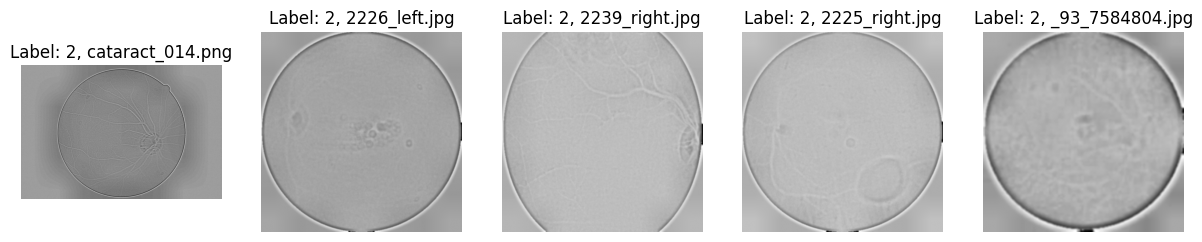

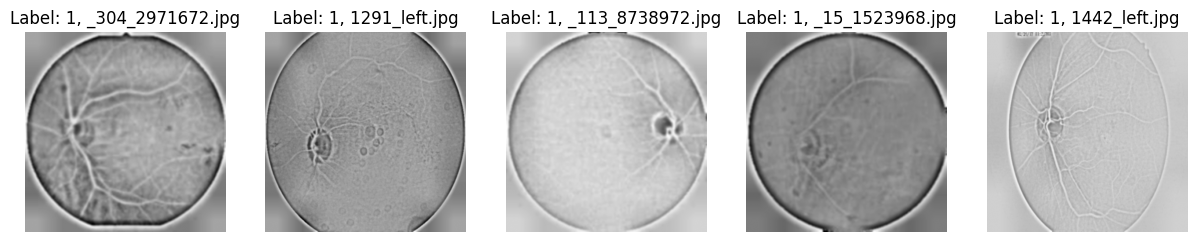

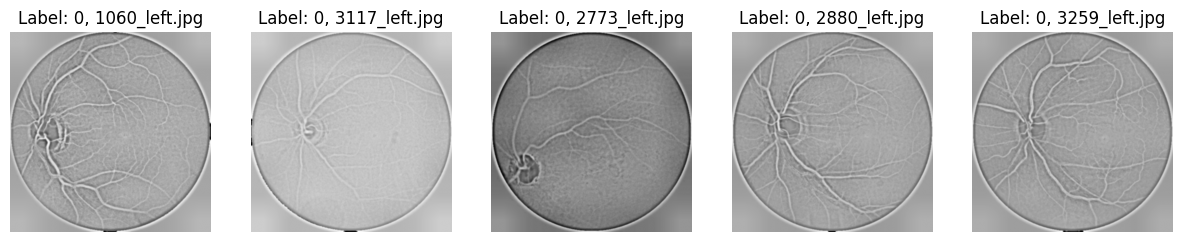

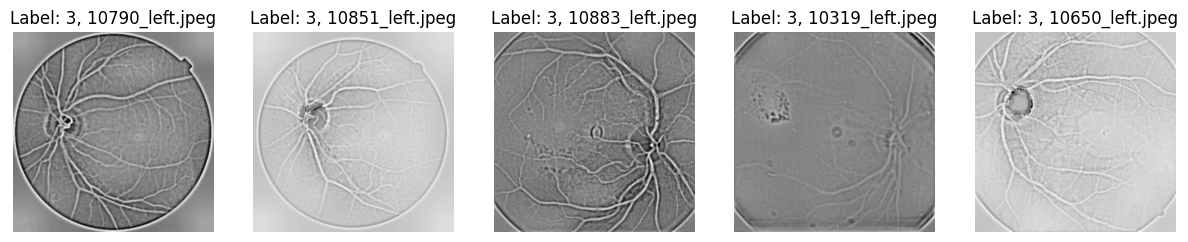

In [ ]:
# prompt: show me 5 image df_processed from each label

import matplotlib.pyplot as plt
# Assuming df_processed DataFrame is already created as in the provided code

for label in df_processed['label'].unique():
    subset = df_processed[df_processed['label'] == label].head(5)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, (index, row) in enumerate(subset.iterrows()):
        axes[i].imshow(row['processed_image'], cmap='gray') # Display processed image in grayscale
        # axes[i].imshow(row['processed_image']) # Display processed image in grayscale
        axes[i].set_title(f"Label: {label}, {os.path.basename(row['image_path'])}")
        axes[i].axis('off')
    plt.show()


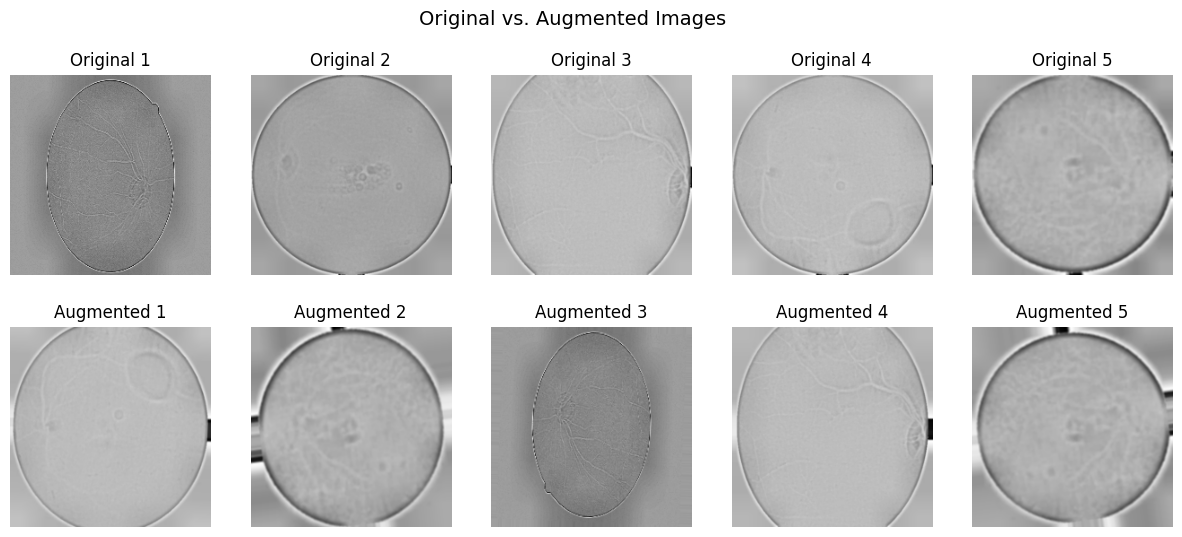

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1️⃣ Get 5 sample images from df_processed
IMG_SIZE = 224
sample_images = df_processed['processed_image'].iloc[:5].tolist()  # Select first 5 images

# Convert images to NumPy and resize them with explicit interpolation
resized_images = [cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR) for img in sample_images]

# Convert images to float32 and normalize to [0,1] before feeding into ImageDataGenerator
original_images = np.array(resized_images).astype('float32') / 255.0  # Normalized float32

# Convert grayscale to 3-channel (RGB-like)
original_images = np.repeat(original_images[..., np.newaxis], 3, axis=-1)  # Now (224, 224, 3)

# 2️⃣ Define Data Augmentation (No explicit transformations applied)
train_datagen = ImageDataGenerator(
    rotation_range=10,   # Rotasi max 15 derajat
    zoom_range=0.1,     # Zoom in/out max 1%
    horizontal_flip=True,  # Flip horizontal
    vertical_flip=True,  # Flip vertikal
    # fill_mode='wrap'  # Hindari black borders dengan refleksi tepi gambar
    fill_mode='nearest'   # Handle empty regions with reflection
)


# Generate augmented images
augmented_images = train_datagen.flow(original_images, batch_size=5, shuffle=True)  # Enable shuffle

# Plot Original vs. Augmented Images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    # Original Image
    # axes[0, i].imshow(original_images[i])
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original {i+1}")

    # Augmented Image (now different each time)
    aug_img = next(augmented_images)[0]  # Get first image from batch
    aug_img = np.clip(aug_img * 255, 0, 255).astype(np.uint8)  # Convert back to uint8 for proper visualization
    # axes[1, i].imshow(aug_img)
    axes[1, i].imshow(aug_img, cmap='gray')
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Augmented {i+1}")

plt.suptitle("Original vs. Augmented Images", fontsize=14)
plt.show()


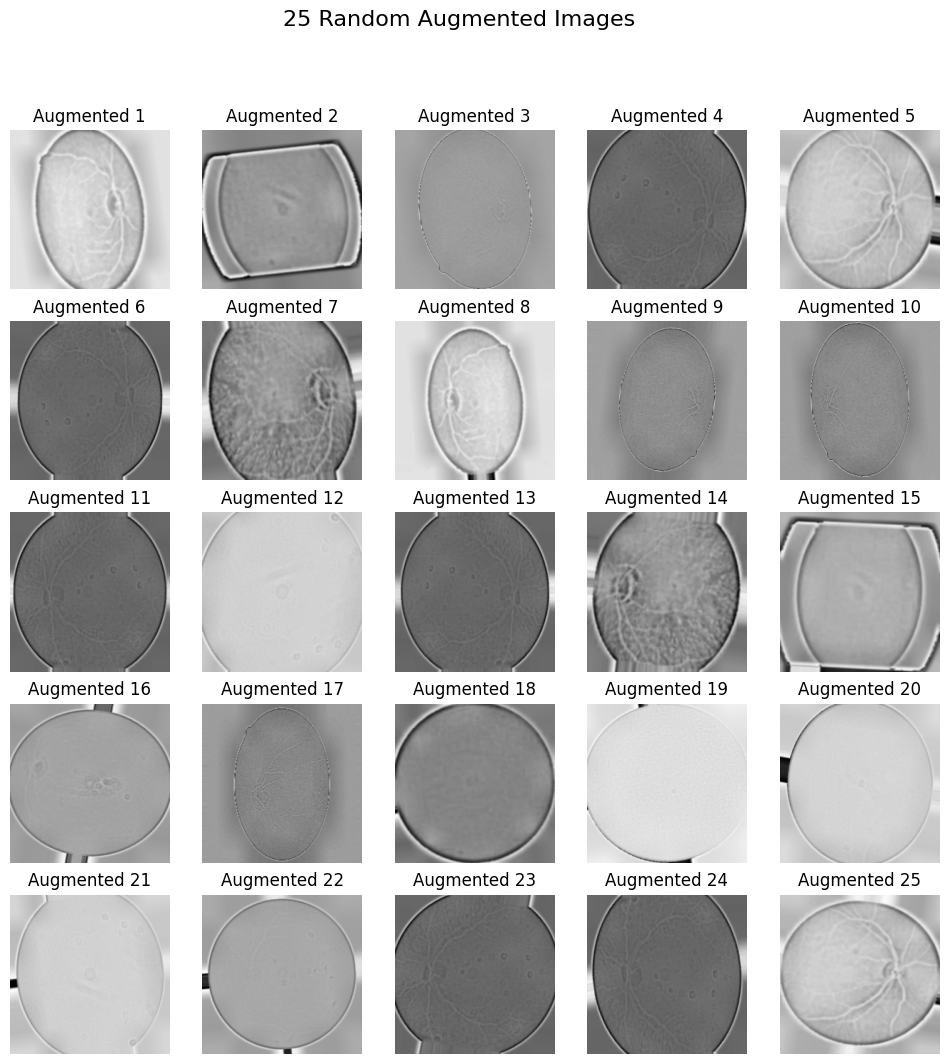

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1️⃣ Load Sample Images
IMG_SIZE = 224
sample_images = df_processed['processed_image'].iloc[:25].tolist()  # Get 25 sample images

# Convert images to NumPy and resize them
resized_images = [cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR) for img in sample_images]

# Normalize images (scale to [0,1])
original_images = np.array(resized_images).astype('float32') / 255.0

# Convert grayscale to 3-channel (RGB-like)
original_images = np.repeat(original_images[..., np.newaxis], 3, axis=-1)  # Shape: (224, 224, 3)

# 2️⃣ Define Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    # fill_mode='nearest'
)

# Generate Augmented Images
augmented_images = train_datagen.flow(original_images, batch_size=25, shuffle=True)  # Generate in batches of 25

# 3️⃣ Plot 25 Random Augmented Images (5x5 Grid)
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i in range(25):
    aug_img = next(augmented_images)[0]  # Get first image from batch
    aug_img = np.clip(aug_img * 255, 0, 255).astype(np.uint8)  # Convert back to uint8 for visualization

    ax = axes[i // 5, i % 5]  # Arrange in 5x5 grid
    ax.imshow(aug_img, cmap='gray')  # Display in grayscale (or remove cmap='gray' for RGB)
    ax.axis("off")
    ax.set_title(f"Augmented {i+1}")

plt.suptitle("25 Random Augmented Images", fontsize=16)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 1️⃣ Preprocessing & Augmentation

IMG_SIZE = 224

# Convert images to NumPy array and resize with interpolation
images = df_processed['processed_image'].to_numpy()
resized_images = [cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR) for img in images]
images = np.stack(resized_images, axis=0)

# Normalize images (scale to range 0-1)
images = images.astype('float32') / 255.0

# Convert grayscale to 3-channel (RGB-like)
images = np.repeat(images[..., np.newaxis], 3, axis=-1)  # Shape: (num_samples, 224, 224, 3)

# Labels
labels = np.array(df_processed['label'].tolist())

# Split dataset into training (70%) and validation (30%)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42, shuffle=True)

# 2️⃣ Data Augmentation

train_datagen = ImageDataGenerator(
    rotation_range=10,       # Rotate images up to 10°
    zoom_range=0.1,          # Zoom in by 10%
    horizontal_flip=True,    # Flip left-right
    fill_mode='nearest'      # Fill empty areas with nearest pixels
)

val_datagen = ImageDataGenerator()  # No augmentation for validation

# Flow images from NumPy arrays (augmented training, normal validation)
train_generator = train_datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=64, shuffle=False)

# 3️⃣ Build Model with L2 Regularization

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout Layer
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = Dropout(0.4)(x)  # Additional Dropout
predictions = Dense(len(df_processed['label'].unique()), activation='softmax', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4️⃣ Compile Model with SGD Optimizer

sgd = SGD(learning_rate=0.01, nesterov=True, momentum=0.9)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5️⃣ Early Stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 6️⃣ Train Model using Augmented Data

history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping])

# 7️⃣ Visualizations

# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 8️⃣ ROC Curve (For Multi-Class Classification)

y_val_bin = label_binarize(y_val, classes=np.unique(labels))  # Convert labels for multi-class ROC
y_pred_prob = model.predict(X_val)

n_classes = y_val_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.2380 - loss: 3.7199 - val_accuracy: 0.2472 - val_loss: 3.4772
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 768ms/step - accuracy: 0.2531 - loss: 3.2860 - val_accuracy: 0.2472 - val_loss: 3.0870
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 772ms/step - accuracy: 0.2463 - loss: 2.9562 - val_accuracy: 0.2472 - val_loss: 2.7598
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 776ms/step - accuracy: 0.2493 - loss: 2.6744 - val_accuracy: 0.2472 - val_loss: 2.5111
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 768ms/step - accuracy: 0.2595 - loss: 2.4526 - val_accuracy: 0.2472 - val_loss: 2.3140
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 762ms/step - accuracy: 0.2505 - loss: 2.2665 - val_accuracy: 0.2583 - val_loss: 2.1505
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 763ms/step - accuracy: 0.2530 - loss: 2.1107 - val_accuracy: 0.2583 - val_loss: 2.0175
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 767ms/step - accuracy: 0.2722 - loss: 1.9838 - val_accura

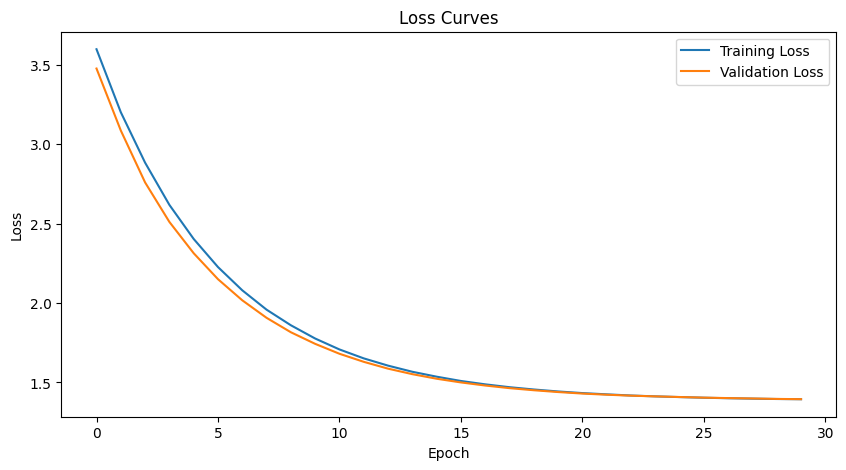

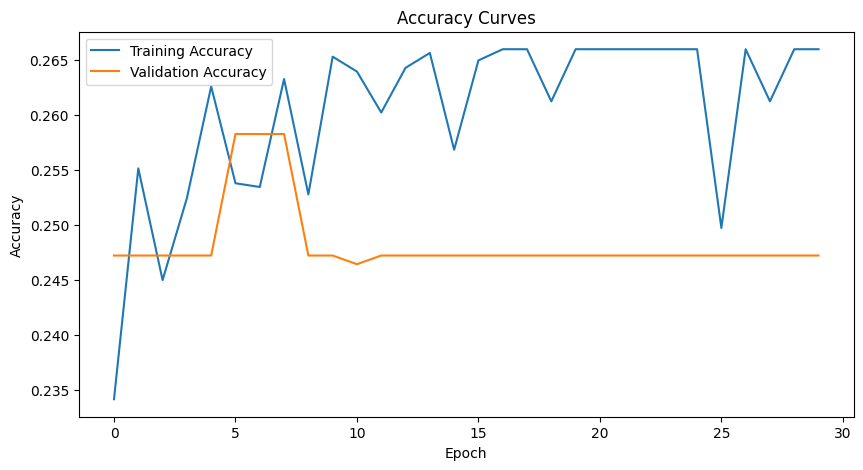

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step


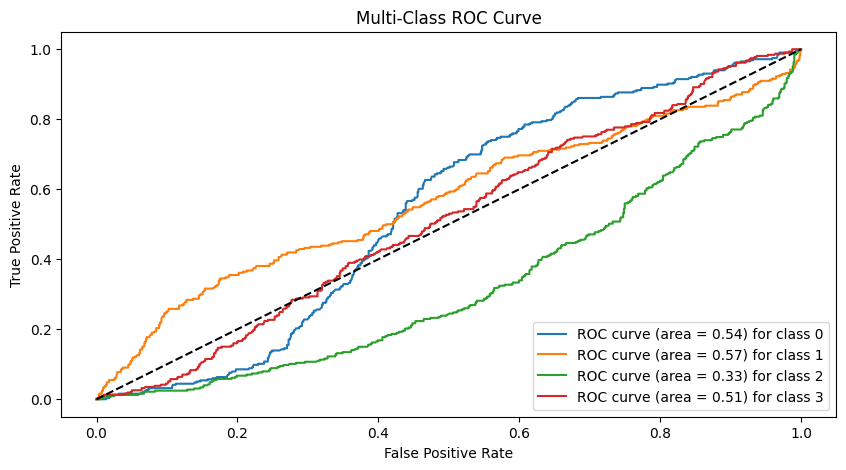

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 1️⃣ Preprocessing & Augmentation

IMG_SIZE = 224

# Convert images to NumPy array and resize with interpolation
images = df_processed['processed_image'].to_numpy()
resized_images = [cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR) for img in images]
images = np.stack(resized_images, axis=0)

# Normalize images (scale to range 0-1)
images = images.astype('float32') / 255.0

# Convert grayscale to 3-channel (RGB-like)
images = np.repeat(images[..., np.newaxis], 3, axis=-1)  # Shape: (num_samples, 224, 224, 3)

# Labels
labels = np.array(df_processed['label'].tolist())

# Split dataset into training (70%) and validation (30%)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42, shuffle=True)

# 2️⃣ Data Augmentation

train_datagen = ImageDataGenerator(
    rotation_range=10,       # Rotate images up to 10°
    width_shift_range=0.1,   # Shift width by 10%
    height_shift_range=0.1,  # Shift height by 10%
    brightness_range=[0.9, 1.1],  # Slight brightness changes
    zoom_range=0.1,          # Zoom in by 10%
    horizontal_flip=True,    # Flip left-right
    fill_mode='nearest'      # Fill empty areas with nearest pixels
)

val_datagen = ImageDataGenerator()  # No augmentation for validation

# Flow images from NumPy arrays (augmented training, normal validation)
train_generator = train_datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=64, shuffle=False)

# 3️⃣ Build Model with L2 Regularization

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout Layer
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = Dropout(0.4)(x)  # Additional Dropout
predictions = Dense(len(df_processed['label'].unique()), activation='softmax', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4️⃣ Compile Model with SGD Optimizer

sgd = SGD(learning_rate=0.01, nesterov=True, momentum=0.9)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5️⃣ Early Stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 6️⃣ Train Model using Augmented Data

history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping])

# 7️⃣ Visualizations

# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 8️⃣ ROC Curve (For Multi-Class Classification)

y_val_bin = label_binarize(y_val, classes=np.unique(labels))  # Convert labels for multi-class ROC
y_pred_prob = model.predict(X_val)

n_classes = y_val_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 76s 388ms/step - accuracy: 0.4886 - loss: 1.1758 - val_accuracy: 0.2583 - val_loss: 1.5099
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.8073 - loss: 0.5298 - val_accuracy: 0.2583 - val_loss: 1.4764
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8196 - loss: 0.4508 - val_accuracy: 0.2583 - val_loss: 1.5692
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8615 - loss: 0.3714 - val_accuracy: 0.2583 - val_loss: 1.5428
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8795 - loss: 0.3180 - val_accuracy: 0.2583 - val_loss: 1.7104
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8932 - loss: 0.2687 - val_accuracy: 0.2583 - val_loss: 1.7765
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9154 - loss: 0.2378 - val_accuracy: 0.2583 - val_loss: 1.8394
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9233 - loss: 0.2212 - val_accuracy: 

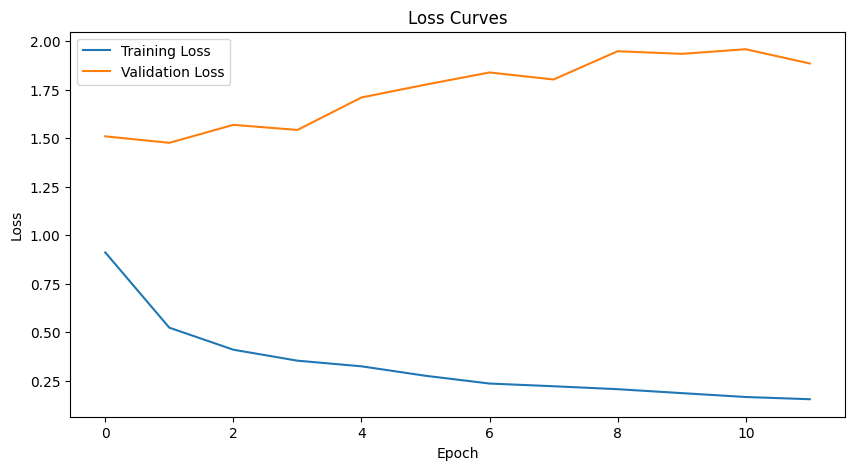

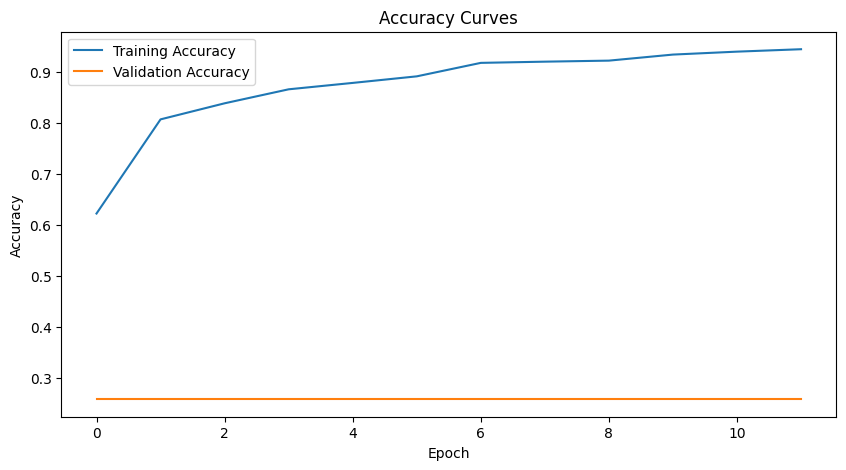

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step


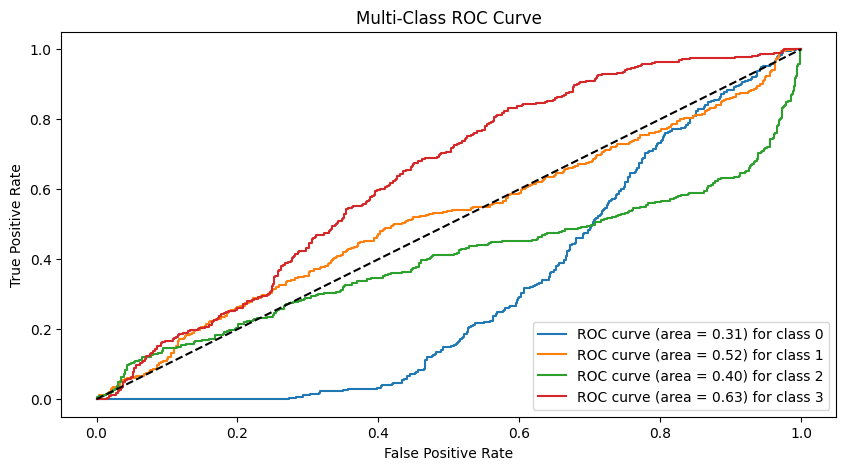

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import cv2 # Import cv2 for resizing

# Assuming df_processed is already created and contains 'processed_image' and 'label' columns

# 1. Image Transformation and Augmentation (Example - adapt as needed)
def augment_image(image):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
  return image

# Prepare data
images = df_processed['processed_image'].to_numpy()
# Convert to NumPy array directly to handle object dtype

# Resize images to a uniform size using cv2.resize
IMG_SIZE = 224 # Choose an appropriate size
resized_images = [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in images]
images = np.stack(resized_images, axis=0)
# Stack images to create a proper array with uniform shape


images = np.array(resized_images) # Use resized images
labels = np.array(df_processed['label'].tolist())
images = images.astype('float32') / 255.0  # Normalize pixel values

# images = np.expand_dims(images, axis=-1) # Add channel dimension if grayscale
# Convert grayscale to 3-channel (RGB-like)
images = np.repeat(images[..., np.newaxis], 3, axis=-1)  # Now (224, 224, 3)
#images = np.repeat(images, 3, axis=-1)  # Now (224, 224, 3)


# 2. Split Dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# 3. Build Model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = MobileNetV3Large(weights=None, include_top=False, input_shape=(images.shape[1], images.shape[2], 1))  # Input shape adjusted

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Dropout Layer
x = Dense(128, activation='relu')(x)
predictions = Dense(len(df_processed['label'].unique()), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4. Compile Model
sgd = SGD(learning_rate=0.001, nesterov=True, momentum=0.9)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5. Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 6. Train Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 7. Visualizations
# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC Curve (For multi-class classification)
from sklearn.preprocessing import label_binarize

y_val_bin = label_binarize(y_val, classes=np.unique(labels)) # Binarize labels for multi-class ROC
y_pred_prob = model.predict(X_val)

n_classes = y_val_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 85s 448ms/step - accuracy: 0.3783 - loss: 1.2791 - val_accuracy: 0.2701 - val_loss: 1.3861
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.7283 - loss: 0.7142 - val_accuracy: 0.2370 - val_loss: 1.3869
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.7871 - loss: 0.5435 - val_accuracy: 0.2370 - val_loss: 1.3874
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.8177 - loss: 0.4593 - val_accuracy: 0.2370 - val_loss: 1.3882
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8401 - loss: 0.4141 - val_accuracy: 0.2370 - val_loss: 1.3889
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8322 - loss: 0.4005 - val_accuracy: 0.2370 - val_loss: 1.3902
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.8655 - loss: 0.3365 - val_accuracy: 0.2370 - val_loss: 1.3919
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.8702 - loss: 0.3301 - val_accurac

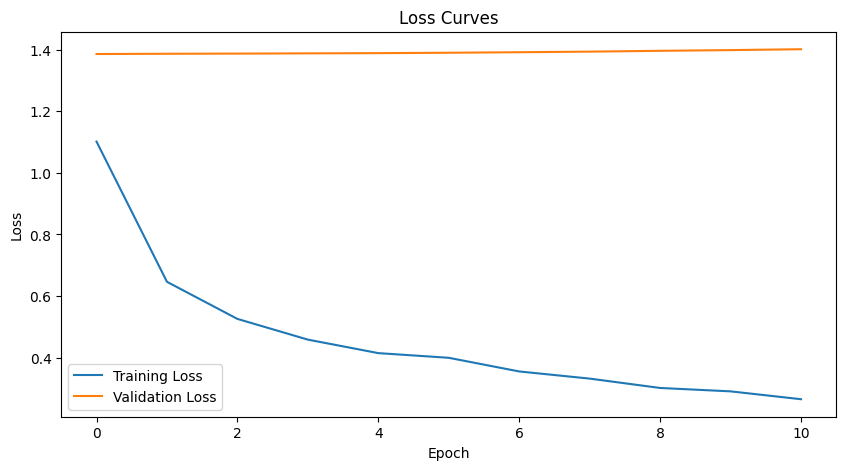

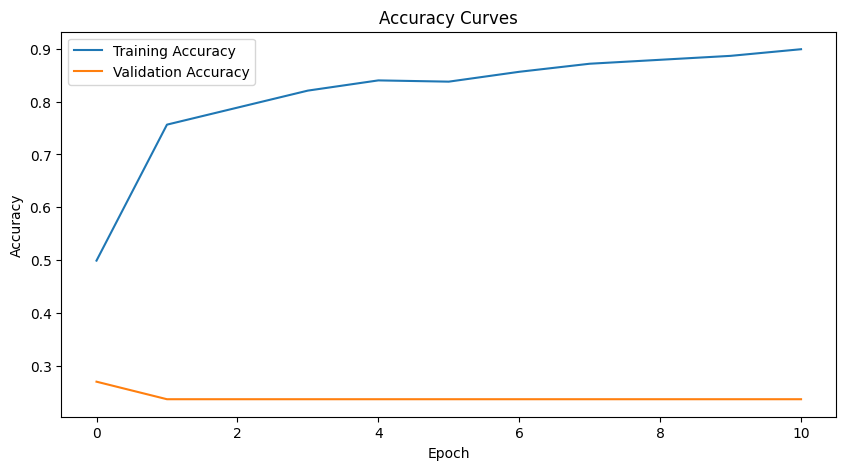

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step


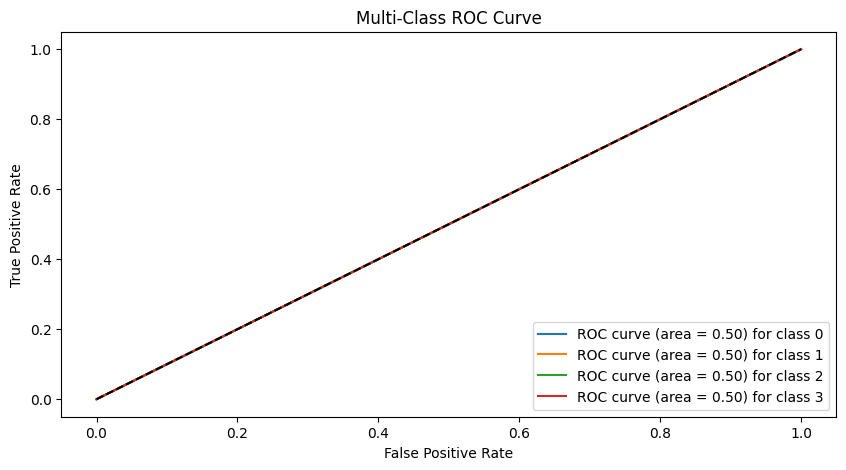

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import cv2 # Import cv2 for resizing

# Assuming df_processed is already created and contains 'processed_image' and 'label' columns

# 1. Image Transformation and Augmentation (Example - adapt as needed)
def augment_image(image):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
  return image

# Prepare data
images = df_processed['processed_image'].to_numpy()
# Convert to NumPy array directly to handle object dtype

# Resize images to a uniform size using cv2.resize
IMG_SIZE = 224 # Choose an appropriate size
resized_images = [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in images]
images = np.stack(resized_images, axis=0)
# Stack images to create a proper array with uniform shape


images = np.array(resized_images) # Use resized images
labels = np.array(df_processed['label'].tolist())
images = images.astype('float32') / 255.0  # Normalize pixel values

images = np.expand_dims(images, axis=-1) # Add channel dimension if grayscale

# 2. Split Dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# 3. Build Model
base_model = MobileNetV3Large(weights=None, include_top=False, input_shape=(images.shape[1], images.shape[2], 1))  # Input shape adjusted

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Dropout Layer
x = Dense(128, activation='relu')(x)
predictions = Dense(len(df_processed['label'].unique()), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4. Compile Model
sgd = SGD(learning_rate=0.001, nesterov=True, momentum=0.9)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5. Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 6. Train Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 7. Visualizations
# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC Curve (For multi-class classification)
from sklearn.preprocessing import label_binarize

y_val_bin = label_binarize(y_val, classes=np.unique(labels)) # Binarize labels for multi-class ROC
y_pred_prob = model.predict(X_val)

n_classes = y_val_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# prompt: lakukan build model dengan dataframe df_processed menggunakan mobilenetv3 large dengan tensorflow library, dimulai transform dan augmentasi image, split dataset 70% raining dan 30% validation, lalu training model dengan jumlah epoch 100 dan menggunakan SDGM Nsterov dengan learning rate 0.001. lakukan early stopping jika model menunjukkan inidkasi overfitting selama 10 epoch dan tambahkan dropout logic. kemudian visualisasi loss curve, accuracy curve, dan ROC curve